### Joshua Koonce
# Ensemble Techniques - Travel Package Purchase Prediction

The objective of this project is to use historical customer data from Visit With Us, a tourism company, to provide actionable insights and improvements to the company's marketing efforts.

Previously, the company found that it was spending far too much money on marketing efforts that were targeting the wrong customers and therefore suffering opportunity cost where it could have used that money on more likely candidates for purchase.

Various bagging and boosting ensemble models will be built and validated against the customer data in order to find the one that most optimally categorizes the customer base and lets the company better profile customers based on their data and company interactions with them.

The data in this dataset is as follows:

- CustomerID: Unique customer ID
- ProdTaken: Whether the customer has purchased a package or not (0: No, 1: Yes)
- Age: Age of customer
- TypeofContact: How customer was contacted (Company Invited or Self Inquiry)
- CityTier: City tier depends on the development of a city, population, facilities, and living standards. The categories are ordered i.e. Tier 1 > Tier 2 > Tier 3
- Occupation: Occupation of customer
- Gender: Gender of customer
- NumberOfPersonVisiting: Total number of persons planning to take the trip with the customer
- PreferredPropertyStar: Preferred hotel property rating by customer
- MaritalStatus: Marital status of customer
- NumberOfTrips: Average number of trips in a year by customer
- Passport: The customer has a passport or not (0: No, 1: Yes)
- OwnCar: Whether the customers own a car or not (0: No, 1: Yes)
- NumberOfChildrenVisiting: Total number of children with age less than 5 planning to take the trip with the customer
- Designation: Designation of the customer in the current organization
- MonthlyIncome: Gross monthly income of the customer

- PitchSatisfactionScore: Sales pitch satisfaction score
- ProductPitched: Product pitched by the salesperson
- NumberOfFollowups: Total number of follow-ups has been done by the salesperson after the sales pitch
- DurationOfPitch: Duration of the pitch by a salesperson to the customer

Import staple data science libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### Import the dataset

In [2]:
tourism = pd.read_excel('Tourism.xlsx', sheet_name='Tourism')

In [3]:
tourism.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [4]:
tourism.shape

(4888, 20)

The dataset has 4,888 rows and 20 columns to start with.

Look at the data types for all columns

In [5]:
pd.DataFrame([tourism.dtypes, tourism.count()], index=['type', 'count']).T

,type,count
CustomerID,int64,4888
ProdTaken,int64,4888
Age,float64,4662
TypeofContact,object,4863
CityTier,int64,4888
DurationOfPitch,float64,4637
Occupation,object,4888
Gender,object,4888
NumberOfPersonVisiting,int64,4888
NumberOfFollowups,float64,4843


It looks like we have some missing values and some data types need correction. Rather than indiscriminately dropping NAs, let's clean up a few columns first where we think we can impute the missing values safely, then drop NAs, to preserve as much data as is reasonable.

We'll also convert discrete values to integers, and change qualitative data to categorical.

# Data Pre-Processing and Cleaning
### Includes cleaning from problems found later in the analysis

In [6]:
# Drop unnecessary columns
if 'CustomerID' in tourism.columns:
    tourism = tourism.drop(['CustomerID'], axis=1)

# Integer conversions can be done in one line
integer_vars = ['Age','DurationOfPitch', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 
                'NumberOfChildrenVisiting']
tourism[integer_vars] = tourism[integer_vars].fillna(tourism.Age.dropna().mean()).astype('int64')

# Category Conversions can be done in one line
category_vars = ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation', 'CityTier']
tourism[category_vars] = tourism[category_vars].astype('category')

# City Tier is categorical numeric, and ordered
from pandas.api.types import CategoricalDtype

cat_dtype = CategoricalDtype(categories=[1, 2, 3], ordered=True)
tourism['CityTier'] = tourism['CityTier'].astype(cat_dtype)
           
# Drop remaining NA rows
tourism = tourism.dropna()

# Gender has some entries for female that are "Fe Male" so fixing those as well:
tourism['Gender'] = tourism['Gender'].replace('Fe Male', 'Female')

# Fixing 37s in columns where 37 does not look reasonable
vars_37 = ['NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'NumberOfChildrenVisiting']
for var in vars_37:
    tourism[var] = tourism[var].replace(37, tourism[var].median())

# A couple additional fixes on data points that look out of range:
tourism['NumberOfTrips'].where(tourism['NumberOfTrips'] < 10, tourism['NumberOfTrips'].median(), inplace=True)
tourism['DurationOfPitch'].where(tourism['DurationOfPitch'] < 30, tourism['DurationOfPitch'].median(), inplace=True) 

In [7]:
tourism.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,1,41,Self Enquiry,3,6,Salaried,Female,3,3,Deluxe,3,Single,1,1,2,1,0,Manager,20993.0
1,0,49,Company Invited,1,14,Salaried,Male,3,4,Deluxe,4,Divorced,2,0,3,1,2,Manager,20130.0
2,1,37,Self Enquiry,1,8,Free Lancer,Male,3,4,Basic,3,Single,7,1,3,0,0,Executive,17090.0
3,0,33,Company Invited,1,9,Salaried,Female,2,3,Basic,3,Divorced,2,1,5,1,1,Executive,17909.0
4,0,37,Self Enquiry,1,8,Small Business,Male,2,3,Basic,4,Divorced,1,0,5,1,0,Executive,18468.0


Check type and missing values again.

In [8]:
pd.DataFrame([tourism.dtypes, tourism.count()], index=['type', 'count']).T

,type,count
ProdTaken,int64,4655
Age,int64,4655
TypeofContact,category,4655
CityTier,category,4655
DurationOfPitch,int64,4655
Occupation,category,4655
Gender,category,4655
NumberOfPersonVisiting,int64,4655
NumberOfFollowups,int64,4655
ProductPitched,category,4655


The DataFrame is looking a lot cleaner now, with no missing values and data types corrected.

Quick look at Categorical variables and their unique values to ensure we don't have any oddities:

In [9]:
[tourism[column].value_counts() for column in tourism.columns if tourism[column].dtypes.name == 'category']

[Self Enquiry       3306
 Company Invited    1349
 Name: TypeofContact, dtype: int64,
 1    3025
 3    1438
 2     192
 Name: CityTier, dtype: int64,
 Salaried          2263
 Small Business    1970
 Large Business     420
 Free Lancer          2
 Name: Occupation, dtype: int64,
 Male      2781
 Female    1874
 Name: Gender, dtype: int64,
 Basic           1755
 Deluxe          1586
 Standard         742
 Super Deluxe     342
 King             230
 Name: ProductPitched, dtype: int64,
 Married      2228
 Divorced      902
 Single        843
 Unmarried     682
 Name: MaritalStatus, dtype: int64,
 Executive         1755
 Manager           1586
 Senior Manager     742
 AVP                342
 VP                 230
 Name: Designation, dtype: int64]

# Perform and Exploratory Data Analysis and Provide Insights

In [10]:
tourism.describe()

,ProdTaken,Age,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
count,4655.000000,4655.000000,4655.000000,4655.000000,4655.000000,4655.000000,4655.000000,4655.000000,4655.000000,4655.000000,4655.000000,4655.000000
mean,0.190763,37.668528,13.594415,2.934694,3.734909,3.573362,3.247476,0.292589,3.073684,0.620838,1.212675,23619.853491
std,0.392945,9.236374,5.710880,0.720524,1.001597,0.794358,1.755519,0.455000,1.366438,0.485231,0.850624,5380.698361
min,0.000000,18.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000
25%,0.000000,31.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20346.000000
50%,0.000000,37.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,1.000000,1.000000,22347.000000
75%,0.000000,44.000000,16.000000,3.000000,4.000000,4.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25571.000000
max,1.000000,61.000000,29.000000,5.000000,6.000000,5.000000,8.000000,1.000000,5.000000,1.000000,3.000000,98678.000000


Most of the variables are fairly normally distributed. Age, Number of Trips, and Income appear to be clearly right-skewed.

### Univariate Distributions EDA

Let's get the distributions of each numeric variable. Many are discrete.

In [11]:
## Define a function to plot all variables distributions, and if possible, a boxplot to show outliers and skew

def plot_uv(df, column):
    print('\tUnivariate Analysis: ', col)
    
    if df[column].dtypes.name != 'category':
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

        # assigning a graph to each axis
        sns.boxplot(x=df[column], ax=ax_box)
        sns.histplot(data=df, x=column, ax=ax_hist)

        # Remove x axis name for the boxplot
        ax_box.set(xlabel='')
        plt.show()
    else:
        sns.histplot(data=df, x=column)
        plt.show()

	Univariate Analysis:  ProdTaken


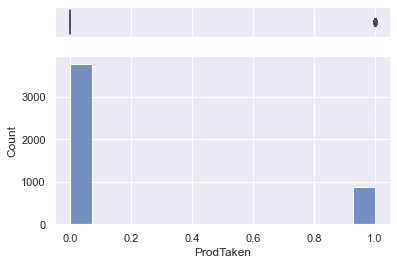

	Univariate Analysis:  Age


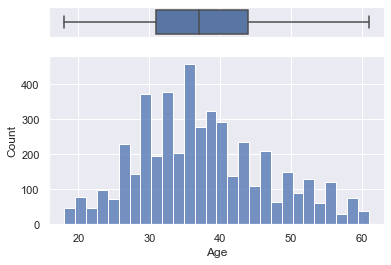

	Univariate Analysis:  TypeofContact


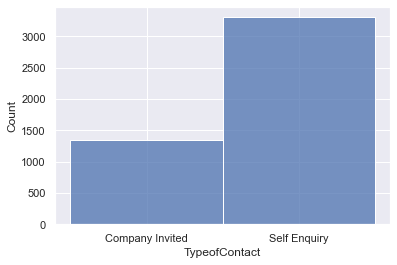

	Univariate Analysis:  CityTier


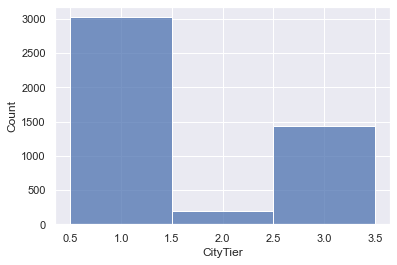

	Univariate Analysis:  DurationOfPitch


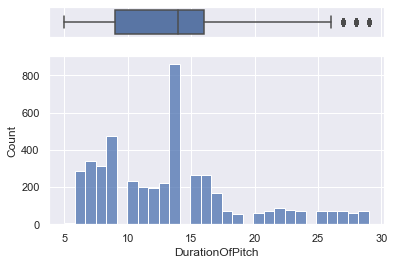

	Univariate Analysis:  Occupation


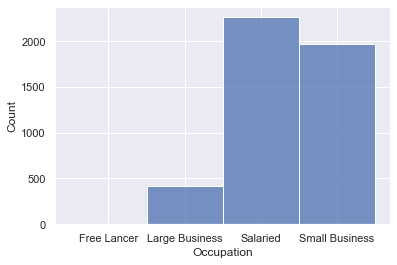

	Univariate Analysis:  Gender


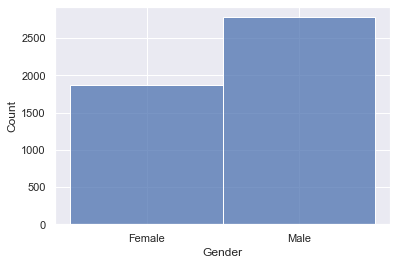

	Univariate Analysis:  NumberOfPersonVisiting


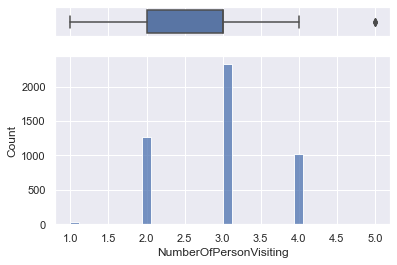

	Univariate Analysis:  NumberOfFollowups


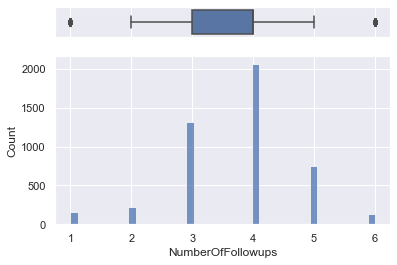

	Univariate Analysis:  ProductPitched


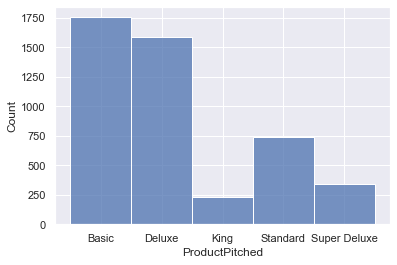

	Univariate Analysis:  PreferredPropertyStar


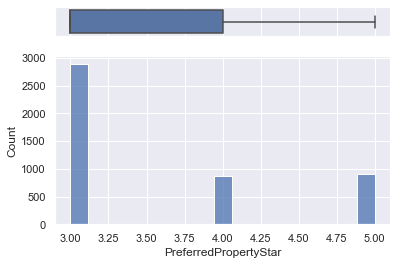

	Univariate Analysis:  MaritalStatus


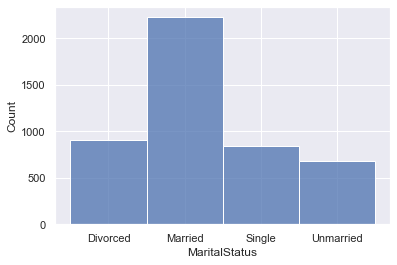

	Univariate Analysis:  NumberOfTrips


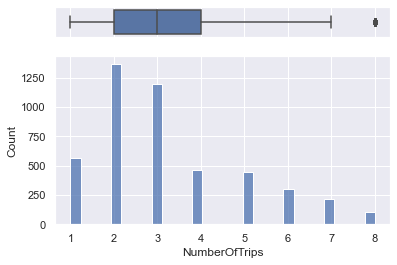

	Univariate Analysis:  Passport


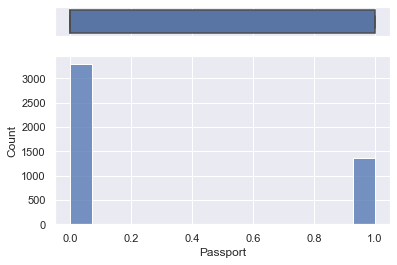

	Univariate Analysis:  PitchSatisfactionScore


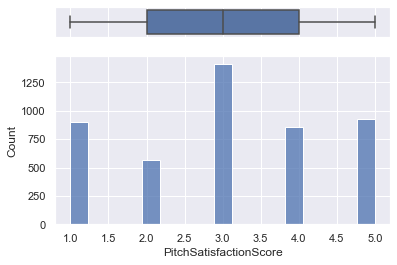

	Univariate Analysis:  OwnCar


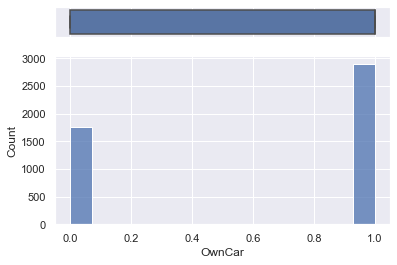

	Univariate Analysis:  NumberOfChildrenVisiting


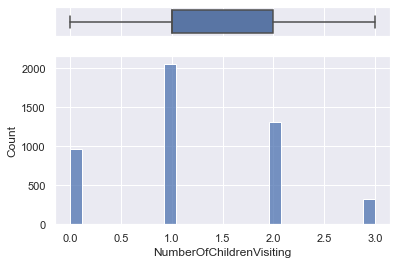

	Univariate Analysis:  Designation


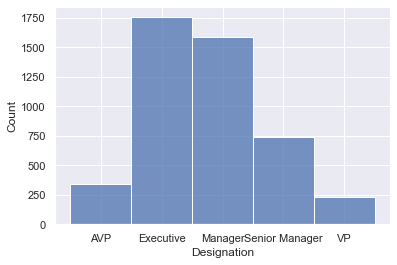

	Univariate Analysis:  MonthlyIncome


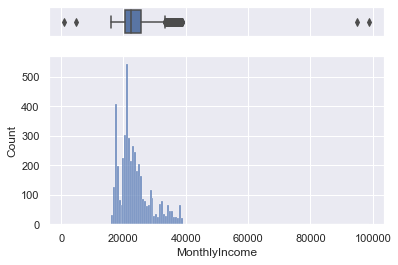

In [12]:
for col in tourism.columns:
        plot_uv(tourism, col)

- Age is roughly normally distributed, peaking at 37-38
- CityTier is most commonly 1 or 3
- Duration of pitch ranges between 9 and 16 minutes on average
- NumberOfPersonVisiting is discrete but roughly normally distributed
- Same with NumberofFollowups
- Most customers are after a 3 star property.
- Number of trips is right skewed but averages/medians at around 3
- About double the amount of customer have no passport compared to those that do have one
- Pitch satisfaction is uniformly distributed but does spike higher on 3
- More customers own a car than do not
- Number of children visiting is most commonly 1 or 2
- Median monthly income is 22k; max is 98k, deemed not a true outlier

Just taking a look at salaries over 60000 to see if they are reasonable:

In [13]:
tourism[tourism['MonthlyIncome'] > 60000]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
38,0,36,Self Enquiry,1,11,Salaried,Female,2,4,Basic,3,Divorced,1,1,2,1,0,Executive,95000.0
2482,0,37,Self Enquiry,1,12,Salaried,Female,3,5,Basic,5,Divorced,2,1,2,1,1,Executive,98678.0


Self enquiries result in sales more frequently than company solicited.

### Plots of Individual Variables in Relation to ProdTaken

In [14]:
def plot_comp(df, column, comparison_var):
    print('\tResponse Analysis: ' + col + ' vs. ' + str(comparison_var))
    
    sns.histplot(x=df[column], hue=df[comparison_var]);
    plt.show()

	Response Analysis: ProdTaken vs. ProdTaken


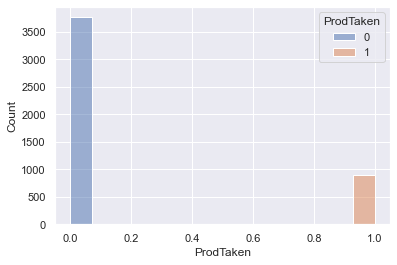

	Response Analysis: Age vs. ProdTaken


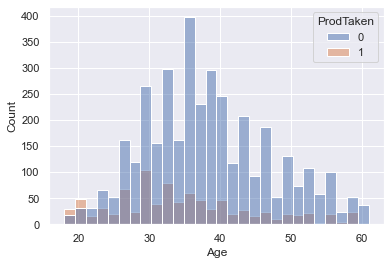

	Response Analysis: TypeofContact vs. ProdTaken


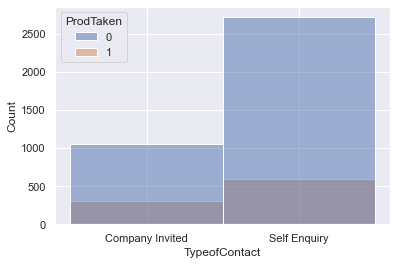

	Response Analysis: CityTier vs. ProdTaken


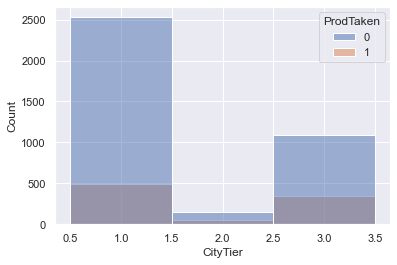

	Response Analysis: DurationOfPitch vs. ProdTaken


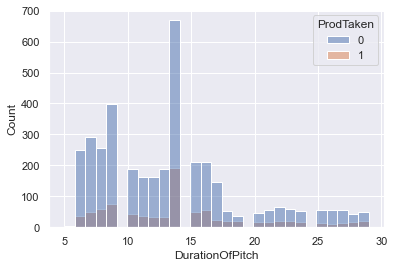

	Response Analysis: Occupation vs. ProdTaken


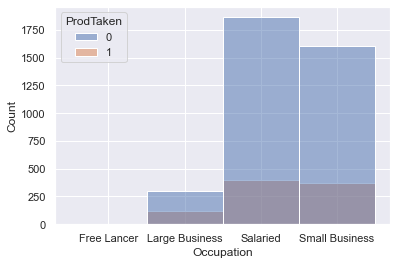

	Response Analysis: Gender vs. ProdTaken


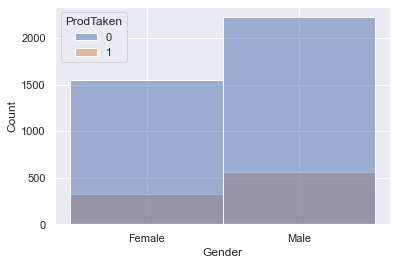

	Response Analysis: NumberOfPersonVisiting vs. ProdTaken


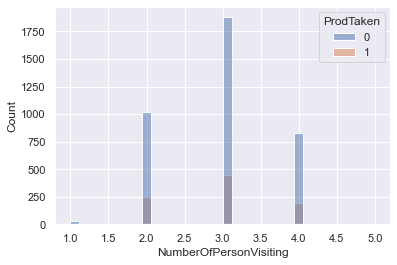

	Response Analysis: NumberOfFollowups vs. ProdTaken


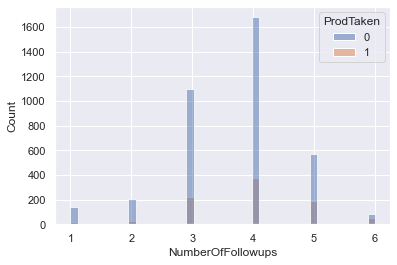

	Response Analysis: ProductPitched vs. ProdTaken


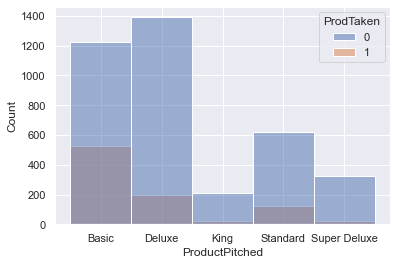

	Response Analysis: PreferredPropertyStar vs. ProdTaken


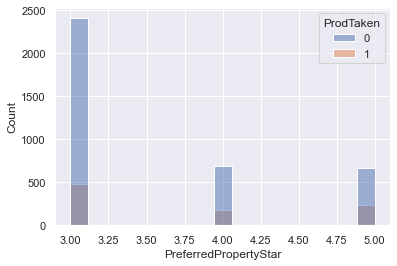

	Response Analysis: MaritalStatus vs. ProdTaken


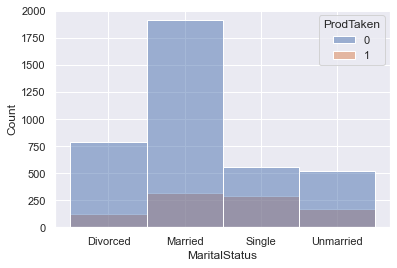

	Response Analysis: NumberOfTrips vs. ProdTaken


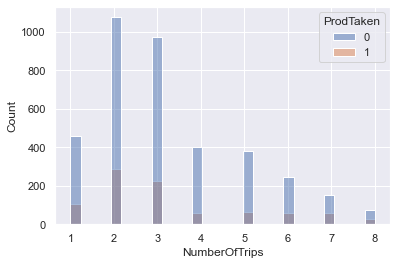

	Response Analysis: Passport vs. ProdTaken


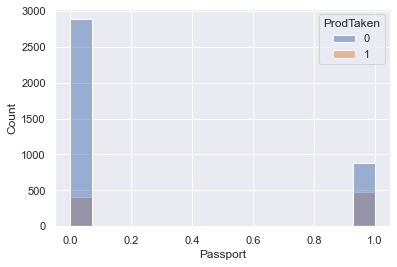

	Response Analysis: PitchSatisfactionScore vs. ProdTaken


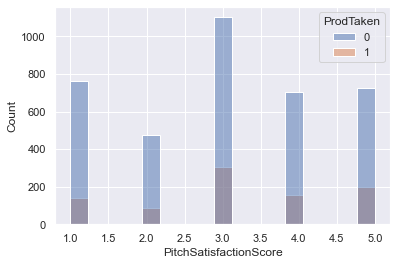

	Response Analysis: OwnCar vs. ProdTaken


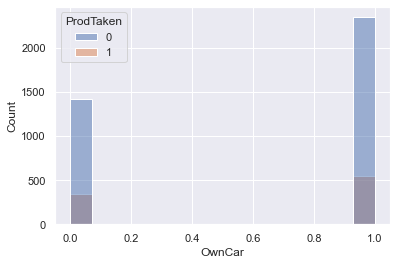

	Response Analysis: NumberOfChildrenVisiting vs. ProdTaken


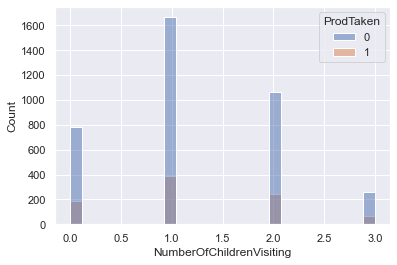

	Response Analysis: Designation vs. ProdTaken


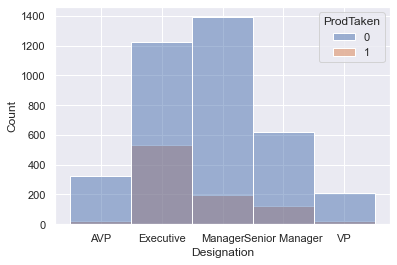

	Response Analysis: MonthlyIncome vs. ProdTaken


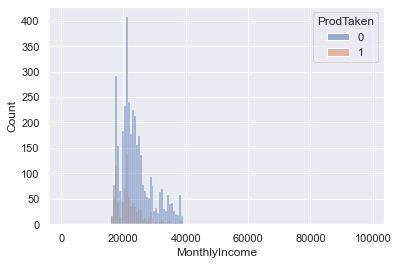

In [15]:
for col in tourism.columns:
        plot_comp(tourism, col, 'ProdTaken')

Insights based on Variables vs. ProdTaken:
- Those of a lower age tend to take the product more.
- Males purchase more often, but the percentage of each gender that purchases is similar.
- Most purchases come from Tier 1 or 3 cities, but percentage-wise more people in Tier 3 cities purchase.
- The product is taken most when the pitch is between 5 and 15 minutes. There appears to be two modes here indicating optimal pitch lengths of around 8 and 14 minutes.
- Salaried and Small Business customers purchase the most, but Large Business purchases quite a bit percentage-wise in relation to how many customers there are.
- Slight advantage to 3 persons visiting when product is taken.
- 3-5 followups seems to be the sweet spot, with 4 being the best chance of product taken.
- Most sales come from 3 star preference customers.
- The most frequent marital status is Married, with a roughly uniform distribution of the remaining options. The highest percentage of folks within a marital status that take the product are Single with approx 50% as many taking it as not taking it, but Married customers take the product from a total count standpoint slightly more than Singles.
- Most customers are self-inquiries, and self-inquiries result in roughly double the takers.
- 2-3 trips seems to get the best success rate.
- Having a passport seems to lead to a higher percentage of ProdTaken.
- Most customers that purchase have a pitch sat score of 3, but those with pitch sat scores of 4 and 5 purchase frequently too. Some purchasing customers don't seem to care much about the pitch. Not a huge difference here.
- There are almost no freelancers, large business owners aren't common, and the majority of customers are salaried or small business owners. Executives and Managers are the most frequent customers.
- Males are customers slightly more often than females and purchase more often.
- Most products pitched are Basic or Deluxe, with Standard and Super Deluxe coming in 3rd and 4th. King is not pitched very often. The acceptance of the product follows roughly the same proportion.

### Bi-variate and Univariate Distribution (PairPlot)

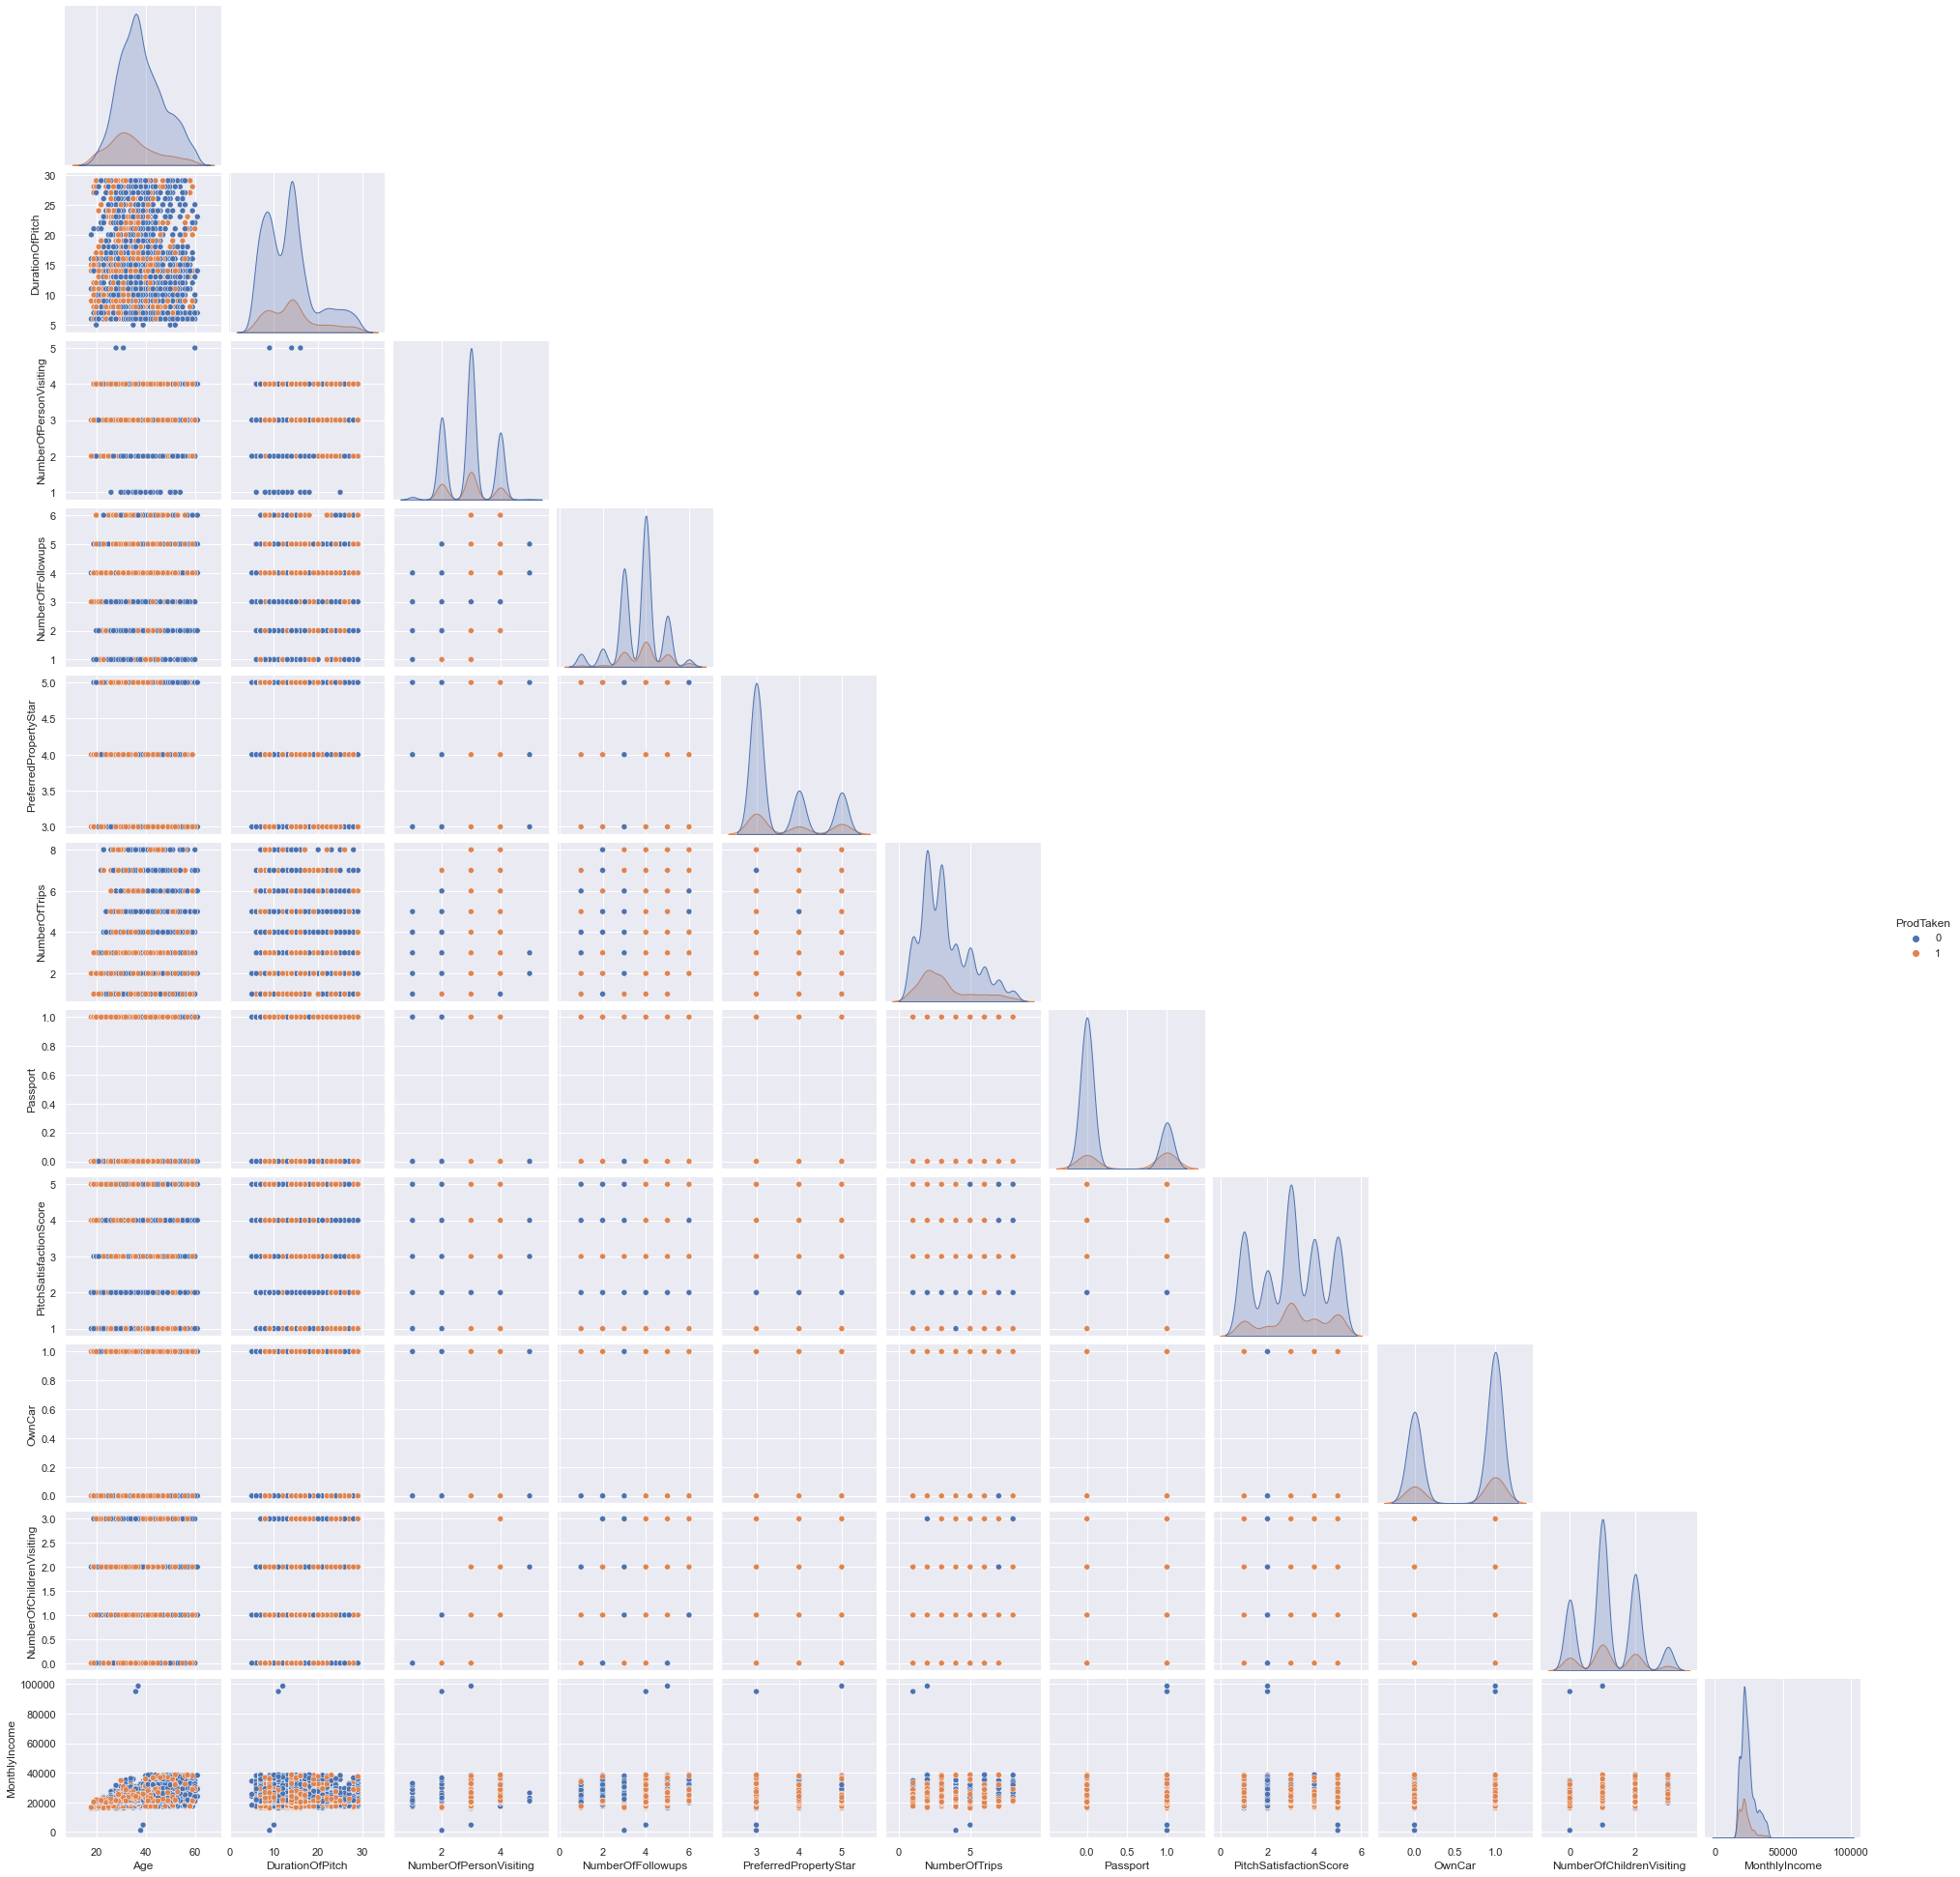

In [16]:
sns.pairplot(tourism, corner=True, diag_kind='kde', hue='ProdTaken');

The distribution of each variable for those who took the product vs didn't are roughly the same for each variable as is evident from the diagonal plots. 

The exceptions: Age, which tends to be lower when the product is taken. DurationOfPitch, longer pitches tend to result in no purchase. Those without a Passport tend to not take the product more frequently.

It's tough to discern any high confidence patterns in the bi-variate scatterplots, particularly with discrete values. The things I can see from the plots are most product takers are younger, with lower incomes, prefer 3 star properties, and tend to have more than a couple visits and followups.

Taking a look at a Correlation Heatmap to get an idea of how variables are moving with one another.

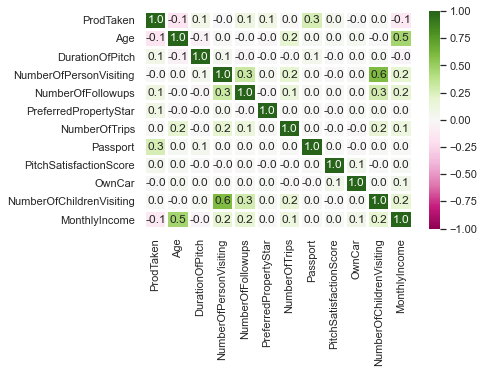

In [17]:
sns.heatmap(tourism.corr(), vmin=-1, vmax=1, linewidths=2, annot=True, fmt='.1f', cmap='PiYG');

It looks like there are only a few moderately correlated variables in this dataset, such as Age vs. Income and Number of Persons vs. Number of Children visiting.

In regard to ProdTaken, which is what we are interested in, Age and Monthly income seem to be negatively correlated and Passport seems to be the highest positive correlation with NumberOfFollowups, PreferredPropertyStar, and DurationofPitch also positively correlated.

No variables look so closely correlated that any should be left out.

# Model Building

#### For this business problem, I will use the F1 score as my primary metric of interest. 

#### In my opinion, Precision is a very important base factor because we want to focus marketing on the customers that will buy (True Positives) and leave out the ones that won't (False Positives), but Recall is also important because we don't want to miss customers that would have bought (False Negatives). I'm going to strike a balance and choose F1 score as my scoring metric which is the harmonic mean of Precision and Recall.

Note: Model performance will be commented on after all models have been built rather than after each model.

Establish Confusion Matrix Metrics function definition.

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import confusion_matrix  


def Classification_Metrics(train_targets, test_targets, train_pred, test_pred):
   
    scores = []
    
    train_acc = round(accuracy_score(train_targets, train_pred), ndigits=2)
    train_prec = round(precision_score(train_targets, train_pred), ndigits=2)
    train_rec = round(recall_score(train_targets, train_pred), ndigits=2)
    train_f1 = round(f1_score(train_targets, train_pred), ndigits=2)
    
    test_acc = round(accuracy_score(test_targets, test_pred), ndigits=2)
    test_prec = round(precision_score(test_targets, test_pred), ndigits=2)
    test_rec = round(recall_score(test_targets, test_pred), ndigits=2)
    test_f1 = round(f1_score(test_targets, test_pred), ndigits=2)

    scores.extend((train_acc, train_prec, train_rec, train_f1, test_acc, test_prec, test_rec, test_f1))
        
    print("Training Set Metrics:")
    print('Accuracy: ', train_acc)
    print('Precision: ', train_prec)
    print('Recall: ', train_rec)
    print('F1: ', train_f1)
    
    print("\nTest (Holdout) Set Metrics:")
    print('Accuracy: ', test_acc)
    print('Precision: ', test_prec)
    print('Recall: ', test_rec)
    print('F1: ', test_f1)
   
    print("\nConfusion Matrix for Test Metrics")
    # create the confusion matrix
    conf_matrix = confusion_matrix(test_targets, test_pred)
    
    # create the heatmap display
    heatmap = sns.heatmap(conf_matrix, cmap='magma', annot=True, fmt='d');
    heatmap.set_ylabel('actual')
    heatmap.set_xlabel('prediction')
    heatmap.plot()
    
    # print the heatmap with some indicator printouts since sklearn does its confusion matrix backwards
    print('\t\tTN\t\tFP\n')

    print('\t\tFN\t\tTP')
    
    return scores

In [19]:
model_scores = pd.DataFrame(columns=['train_acc', 'train_prec', 'train_rec', 'train_f1', 'test_acc', 'test_prec', 
                                     'test_rec', 'test_f1'])

In order to model, I want to create dummy variables for the categorical variables:

In [20]:
dummies = pd.get_dummies(tourism[category_vars], drop_first=True)

tourism = pd.concat([tourism, dummies], axis=1)
tourism.drop(labels=category_vars, axis=1, inplace=True)

tourism.head()

,ProdTaken,Age,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,...,ProductPitched_Super Deluxe,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Unmarried,Designation_Executive,Designation_Manager,Designation_Senior Manager,Designation_VP,CityTier_2,CityTier_3
0,1,41,6,3,3,3,1,1,2,1,...,0,0,1,0,0,1,0,0,0,1
1,0,49,14,3,4,4,2,0,3,1,...,0,0,0,0,0,1,0,0,0,0
2,1,37,8,3,4,3,7,1,3,0,...,0,0,1,0,1,0,0,0,0,0
3,0,33,9,2,3,3,2,1,5,1,...,0,0,0,0,1,0,0,0,0,0
4,0,37,8,2,3,4,1,0,5,1,...,0,0,0,0,1,0,0,0,0,0


### Features and Targets:  Train/Test Split

Lastly, I want to split the dataset into features and targets before I get to model building.

In [21]:
x = tourism.drop(['ProdTaken'], axis=1)
y = tourism['ProdTaken']

print(len(x)/len(y))

1.0


The data is ready to feed into the modeling process.

Import the Machine Learning libraries. I'll need for both a Bagging and a Random Forest model.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import metrics

# Define the scorer for grid search to be what is most important to us for the business case
scorer = metrics.make_scorer(metrics.f1_score)

In [23]:
y.value_counts()

0    3767
1     888
Name: ProdTaken, dtype: int64

There is some significant imbalance in the target classes, so I'll apply class weights to the train/test split to ensure stratified sampling. I'll designate the Test holdout set at 30% of overall samples.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, stratify=y, random_state=1337)

[len(x) for x in [x_train, x_test, y_train, y_test]]

[3258, 1397, 3258, 1397]

## Basic Decision Tree

In [25]:
%%time

# instantiate a classifier
dt = DecisionTreeClassifier(random_state=1337)

# fit the model to training data
dt.fit(x_train, y_train)

Wall time: 14.5 ms


DecisionTreeClassifier(random_state=1337)

Feature Importance (Top 10):

In [26]:
pd.DataFrame(data=dt.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
MonthlyIncome,0.151806
DurationOfPitch,0.124945
Age,0.114281
Passport,0.081301
NumberOfTrips,0.069194
PitchSatisfactionScore,0.061452
Designation_Executive,0.054732
NumberOfFollowups,0.039670
PreferredPropertyStar,0.033179
MaritalStatus_Single,0.026727


Make Predictions

In [27]:
dt_pred_train = dt.predict(x_train)
dt_pred_test = dt.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0

Test (Holdout) Set Metrics:
Accuracy:  0.88
Precision:  0.66
Recall:  0.72
F1:  0.69

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


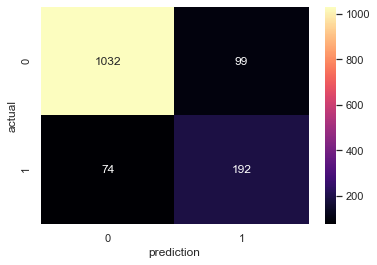

In [28]:
model_scores.loc['Basic Decision Tree'] = Classification_Metrics(y_train, y_test, dt_pred_train, dt_pred_test)

## Bagging Ensemble Techniques

### Bagging Classifier (Bagged Tree)

First an untuned classifier:

In [29]:
%%time

# instantiate a classifier
bc = BaggingClassifier(random_state=1337)

# fit the model to training data
bc.fit(x_train, y_train)

Wall time: 94 ms


BaggingClassifier(random_state=1337)

Feature Importance (Top 10):

Make Predictions

In [30]:
bag_pred_train = bc.predict(x_train)
bag_pred_test = bc.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  0.99
Precision:  1.0
Recall:  0.96
F1:  0.98

Test (Holdout) Set Metrics:
Accuracy:  0.9
Precision:  0.86
Recall:  0.59
F1:  0.7

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


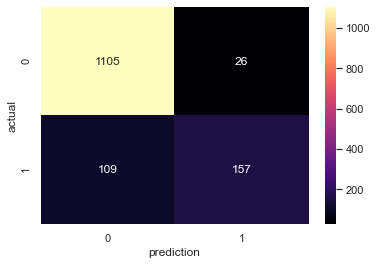

In [31]:
model_scores.loc['Bagging'] = Classification_Metrics(y_train, y_test, bag_pred_train, bag_pred_test)

### Model Performance Improvement: Tuned Bagging

In [32]:
%%time

# instantiate a classifier
bc_tuned = BaggingClassifier(random_state=1337)

# hyperparameters
hp = {'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
      'max_features': [0.7, 0.8, 0.9, 1],
      'n_estimators' : [20, 40, 60, 80, 100]}

# perform the grid search for best estimator
grid_search = GridSearchCV(bc_tuned, hp, scoring=scorer, cv=5)
grid_search = grid_search.fit(x_train, y_train)

# store the tuned model and fit to the training data
bc_tuned = grid_search.best_estimator_
bc_tuned.fit(x_train, y_train)

Wall time: 2min 13s


BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=100,
                  random_state=1337)

So these are the best hyperparameters within my grid search for a Recall-based model.

Make Predictions

In [33]:
bct_pred_train = bc_tuned.predict(x_train)
bct_pred_test = bc_tuned.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0

Test (Holdout) Set Metrics:
Accuracy:  0.92
Precision:  0.91
Recall:  0.65
F1:  0.76

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


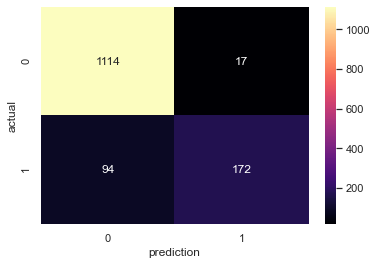

In [34]:
model_scores.loc['Tuned Bagging'] = Classification_Metrics(y_train, y_test, bct_pred_train, bct_pred_test)

### Random Forest Classifier

First, the untuned Random Forest:

In [35]:
%%time

# instantiate a classifier
rf = RandomForestClassifier(random_state=1337)

# Fit the model
rf.fit(x_train, y_train)

Wall time: 274 ms


RandomForestClassifier(random_state=1337)

Feature Importance (Top 10):

In [36]:
pd.DataFrame(data=rf.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
MonthlyIncome,0.127170
Age,0.123913
DurationOfPitch,0.088244
Passport,0.086632
NumberOfTrips,0.066296
PitchSatisfactionScore,0.056398
NumberOfFollowups,0.051866
PreferredPropertyStar,0.040705
NumberOfChildrenVisiting,0.030200
MaritalStatus_Single,0.029851


Make Predictions

In [37]:
rf_pred_train = rf.predict(x_train)
rf_pred_test = rf.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0

Test (Holdout) Set Metrics:
Accuracy:  0.91
Precision:  0.92
Recall:  0.57
F1:  0.7

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


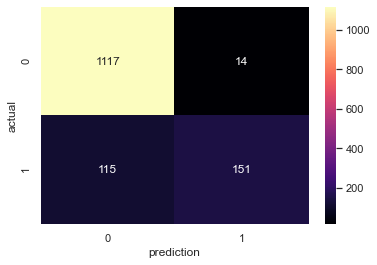

In [38]:
model_scores.loc['Random Forest'] = Classification_Metrics(y_train, y_test, rf_pred_train, rf_pred_test)

### Model Performance Improvement: Tuned Random Forest

In [39]:
%%time

# instantiate a classifier
rf_tuned = RandomForestClassifier(random_state=1337)

# hyperparameters
hp = {'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
      'max_features': [0.7, 0.8, 0.9, 1],
      'n_estimators' : [20, 40, 60, 80, 100],
      'max_depth' : [2, 4, 6, 8, 10]}

# perform the grid search for best estimator
grid_search = GridSearchCV(rf_tuned, hp, scoring=scorer, cv=5)
grid_search = grid_search.fit(x_train, y_train)

# store the tuned model and fit to the training data
rf_tuned = grid_search.best_estimator_
rf_tuned.fit(x_train, y_train)

Wall time: 7min 23s


RandomForestClassifier(max_depth=10, max_features=0.9, max_samples=0.9,
                       n_estimators=60, random_state=1337)

Feature Importance (Top 10):

In [40]:
pd.DataFrame(data=rf_tuned.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
Age,0.132292
MonthlyIncome,0.130860
Passport,0.106970
DurationOfPitch,0.096862
Designation_Executive,0.065300
NumberOfTrips,0.063262
PitchSatisfactionScore,0.045448
NumberOfFollowups,0.042107
MaritalStatus_Single,0.038186
CityTier_3,0.037984


Make Predictions

In [41]:
rft_pred_train = rf_tuned.predict(x_train)
rft_pred_test = rf_tuned.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  0.96
Precision:  1.0
Recall:  0.78
F1:  0.88

Test (Holdout) Set Metrics:
Accuracy:  0.88
Precision:  0.85
Recall:  0.47
F1:  0.61

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


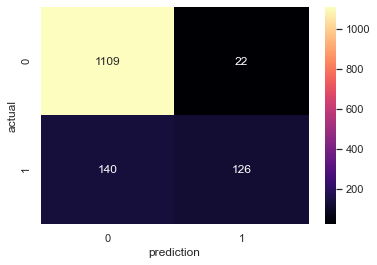

In [42]:
model_scores.loc['Tuned Random Forest'] = Classification_Metrics(y_train, y_test, rft_pred_train, rft_pred_test)

# Boosted Ensemble Techniques

Import additional classifiers needed for boosted approaches.

In [43]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier

### AdaBoost Classifier

In [44]:
%%time

# instantiate a classifier
ab = AdaBoostClassifier(random_state=1337)

# Fit the model
ab.fit(x_train, y_train)

Wall time: 129 ms


AdaBoostClassifier(random_state=1337)

Feature Importance (Top 10):

In [45]:
pd.DataFrame(data=ab.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
MonthlyIncome,0.30
Age,0.14
NumberOfFollowups,0.06
PitchSatisfactionScore,0.06
NumberOfPersonVisiting,0.04
PreferredPropertyStar,0.04
Passport,0.04
MaritalStatus_Unmarried,0.04
ProductPitched_Super Deluxe,0.04
DurationOfPitch,0.04


Make Predictions

In [46]:
ab_pred_train = ab.predict(x_train)
ab_pred_test = ab.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  0.85
Precision:  0.73
Recall:  0.37
F1:  0.49

Test (Holdout) Set Metrics:
Accuracy:  0.84
Precision:  0.67
Recall:  0.31
F1:  0.42

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


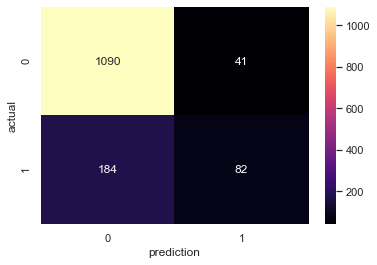

In [47]:
model_scores.loc['AdaBoost'] = Classification_Metrics(y_train, y_test, ab_pred_train, ab_pred_test)

### Model Performance Improvement: Tuned AdaBoost

In [48]:
%%time

# instantiate a classifier
ab_tuned = AdaBoostClassifier(random_state=1337)

# hyperparameters
hp = {'n_estimators' : [20, 40, 60, 80, 100],
      'learning_rate' : [0.01, 0.1, 0.05, 0.5, 1.0]}

# perform the grid search for best estimator
grid_search = GridSearchCV(ab_tuned, hp, scoring=scorer, cv=5)
grid_search = grid_search.fit(x_train, y_train)

# store the tuned model and fit to the training data
ab_tuned = grid_search.best_estimator_
ab_tuned.fit(x_train, y_train)

Wall time: 18.2 s


AdaBoostClassifier(n_estimators=100, random_state=1337)

Feature Importance (Top 10):

In [49]:
pd.DataFrame(data=ab_tuned.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
MonthlyIncome,0.47
Age,0.11
DurationOfPitch,0.09
NumberOfFollowups,0.04
PitchSatisfactionScore,0.04
NumberOfTrips,0.03
MaritalStatus_Unmarried,0.02
ProductPitched_Super Deluxe,0.02
CityTier_3,0.02
PreferredPropertyStar,0.02


Make Predictions

In [50]:
abt_pred_train = ab_tuned.predict(x_train)
abt_pred_test = ab_tuned.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  0.86
Precision:  0.73
Recall:  0.39
F1:  0.51

Test (Holdout) Set Metrics:
Accuracy:  0.84
Precision:  0.66
Recall:  0.31
F1:  0.42

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


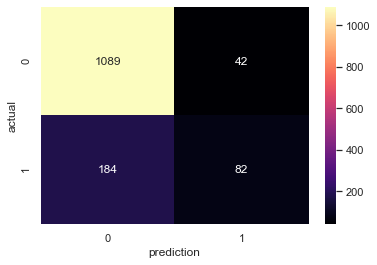

In [51]:
model_scores.loc['AdaBoost Tuned'] = Classification_Metrics(y_train, y_test, abt_pred_train, abt_pred_test)

### Gradient Boost Classifier

In [52]:
%%time

# instantiate a classifier
gb = GradientBoostingClassifier(random_state=1337)

# Fit the model
gb.fit(x_train, y_train)

Wall time: 368 ms


GradientBoostingClassifier(random_state=1337)

Feature Importance (Top 10):

In [53]:
pd.DataFrame(data=gb.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
Passport,0.186121
Age,0.130585
MonthlyIncome,0.128472
Designation_Executive,0.116777
MaritalStatus_Single,0.056307
CityTier_3,0.049281
NumberOfFollowups,0.048058
DurationOfPitch,0.046365
PreferredPropertyStar,0.039331
NumberOfTrips,0.028179


Make Predictions

In [54]:
gb_pred_train = gb.predict(x_train)
gb_pred_test = gb.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  0.9
Precision:  0.89
Recall:  0.52
F1:  0.65

Test (Holdout) Set Metrics:
Accuracy:  0.86
Precision:  0.75
Recall:  0.38
F1:  0.5

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


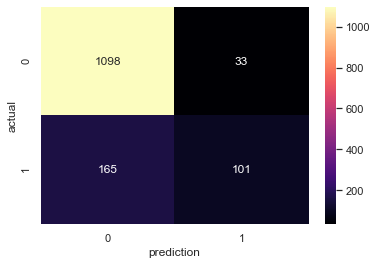

In [55]:
model_scores.loc['Gradient Boost'] = Classification_Metrics(y_train, y_test, gb_pred_train, gb_pred_test)

### Model Performance Improvement: Tuned Gradient Boost

In [56]:
%%time

# instantiate a classifier
gb_tuned = GradientBoostingClassifier(random_state=1337)

# hyperparameters
hp = {'n_estimators' : [20, 40, 60, 80, 100],
      'learning_rate' : [0.01, 0.1, 0.05, 0.5, 1.0],
      'max_depth' : [2, 4, 6, 8, 10]}

# perform the grid search for best estimator
grid_search = GridSearchCV(gb_tuned, hp, scoring=scorer, cv=5)
grid_search = grid_search.fit(x_train, y_train)

# store the tuned model and fit to the training data
gb_tuned = grid_search.best_estimator_
gb_tuned.fit(x_train, y_train)

Wall time: 4min 53s


GradientBoostingClassifier(learning_rate=0.5, max_depth=10, random_state=1337)

In [57]:
pd.DataFrame(data=gb_tuned.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
MonthlyIncome,0.152810
Age,0.118547
DurationOfPitch,0.115636
Passport,0.080635
PitchSatisfactionScore,0.061466
Designation_Executive,0.061358
NumberOfTrips,0.060002
PreferredPropertyStar,0.046048
NumberOfFollowups,0.042306
CityTier_3,0.027501


Make Predictions

In [58]:
gbt_pred_train = gb_tuned.predict(x_train)
gbt_pred_test = gb_tuned.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0

Test (Holdout) Set Metrics:
Accuracy:  0.94
Precision:  0.91
Recall:  0.79
F1:  0.85

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


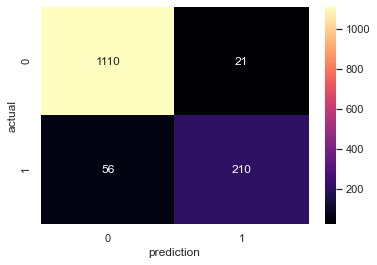

In [59]:
model_scores.loc['Gradient Boost Tuned'] = Classification_Metrics(y_train, y_test, gbt_pred_train, gbt_pred_test)

### XGBoost Classifier


In [60]:
%%time

# instantiate a classifier
xgb = XGBClassifier(random_state=1337, use_label_encoder=False, eval_metric='logloss')

# Fit the model
xgb.fit(x_train, y_train)

Wall time: 173 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, random_state=1337, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Feature Importance (Top 10):

In [61]:
pd.DataFrame(data=xgb.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
Designation_Executive,0.146113
Passport,0.112627
MaritalStatus_Married,0.057336
Occupation_Large Business,0.052713
MaritalStatus_Single,0.050261
ProductPitched_Super Deluxe,0.040780
MaritalStatus_Unmarried,0.040682
CityTier_3,0.039240
ProductPitched_Standard,0.038652
TypeofContact_Self Enquiry,0.032648


Make Predictions

In [62]:
xgb_pred_train = xgb.predict(x_train)
xgb_pred_test = xgb.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  1.0
Precision:  1.0
Recall:  0.99
F1:  1.0

Test (Holdout) Set Metrics:
Accuracy:  0.92
Precision:  0.86
Recall:  0.72
F1:  0.78

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


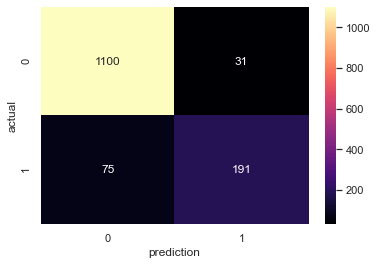

In [63]:
model_scores.loc['XGBoost'] = Classification_Metrics(y_train, y_test, xgb_pred_train, xgb_pred_test)

### Model Performance Improvement: Tuned XGBoost

In [64]:
%%time

# instantiate a classifier
xgb_tuned = XGBClassifier(random_state=1337, use_label_encoder=False, eval_metric='logloss')

# hyperparameters
hp = {'n_estimators' : [60, 80, 100, 200],
      'learning_rate' : [0.01, 0.1, 0.05, 0.5, 1.0],
      'max_depth' : [2, 4, 6, 8, 10]}

# perform the grid search for best estimator
grid_search = GridSearchCV(xgb_tuned, hp, scoring=scorer, cv=5)
grid_search = grid_search.fit(x_train, y_train)

# store the tuned model and fit to the training data
xgb_tuned = grid_search.best_estimator_
xgb_tuned.fit(x_train, y_train)

Wall time: 1min 12s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=24,
              num_parallel_tree=1, random_state=1337, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

Feature Importance (Top 10):

In [65]:
pd.DataFrame(data=xgb_tuned.feature_importances_, columns=["Importance"], index=x_train.columns).sort_values(by="Importance", ascending=False)[:10]

,Importance
Passport,0.110200
Occupation_Large Business,0.084045
Designation_Executive,0.080035
ProductPitched_King,0.067517
CityTier_2,0.059478
MaritalStatus_Single,0.050214
MaritalStatus_Married,0.046904
ProductPitched_Super Deluxe,0.044760
MaritalStatus_Unmarried,0.042488
CityTier_3,0.041430


Make Predictions

In [66]:
xgbt_pred_train = xgb_tuned.predict(x_train)
xgbt_pred_test = xgb_tuned.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0

Test (Holdout) Set Metrics:
Accuracy:  0.92
Precision:  0.86
Recall:  0.72
F1:  0.78

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


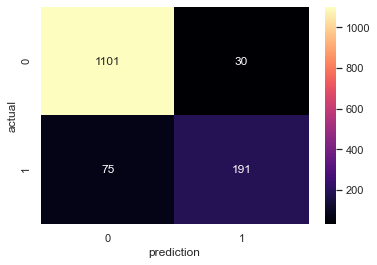

In [67]:
model_scores.loc['XGBoost Tuned'] = Classification_Metrics(y_train, y_test, xgbt_pred_train, xgbt_pred_test)

### Stacking Classifier

I'll be using the best models from above for the stack.

In [68]:
%%time

estimators=[('tbc', BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=100,
                  random_state=1337)),
            ('rft', RandomForestClassifier(max_features=0.9, max_samples=0.9, random_state=1337)),
            ('gbt', GradientBoostingClassifier(learning_rate=0.5, max_depth=10, random_state=1337))]
            

# instantiate a classifier
stk = StackingClassifier(estimators=estimators)

# Fit the model
stk.fit(x_train, y_train)

Wall time: 17.9 s


StackingClassifier(estimators=[('tbc',
                                BaggingClassifier(max_features=0.9,
                                                  max_samples=0.9,
                                                  n_estimators=100,
                                                  random_state=1337)),
                               ('rft',
                                RandomForestClassifier(max_features=0.9,
                                                       max_samples=0.9,
                                                       random_state=1337)),
                               ('gbt',
                                GradientBoostingClassifier(learning_rate=0.5,
                                                           max_depth=10,
                                                           random_state=1337))])

Make Predictions

In [69]:
stk_pred_train = stk.predict(x_train)
stk_pred_test = stk.predict(x_test)

Check Metrics

Training Set Metrics:
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1:  1.0

Test (Holdout) Set Metrics:
Accuracy:  0.94
Precision:  0.9
Recall:  0.77
F1:  0.83

Confusion Matrix for Test Metrics
		TN		FP

		FN		TP


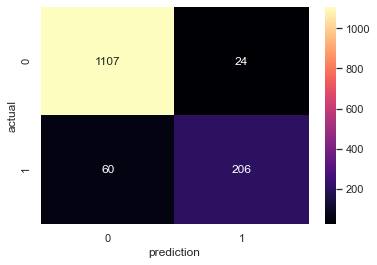

In [70]:
model_scores.loc['Stacking'] = Classification_Metrics(y_train, y_test, stk_pred_train, stk_pred_test)

# Model Performance Evaluation

In [71]:
model_scores

,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
Basic Decision Tree,1.00,1.00,1.00,1.00,0.88,0.66,0.72,0.69
Bagging,0.99,1.00,0.96,0.98,0.90,0.86,0.59,0.70
Tuned Bagging,1.00,1.00,1.00,1.00,0.92,0.91,0.65,0.76
Random Forest,1.00,1.00,1.00,1.00,0.91,0.92,0.57,0.70
Tuned Random Forest,0.96,1.00,0.78,0.88,0.88,0.85,0.47,0.61
AdaBoost,0.85,0.73,0.37,0.49,0.84,0.67,0.31,0.42
AdaBoost Tuned,0.86,0.73,0.39,0.51,0.84,0.66,0.31,0.42
Gradient Boost,0.90,0.89,0.52,0.65,0.86,0.75,0.38,0.50
Gradient Boost Tuned,1.00,1.00,1.00,1.00,0.94,0.91,0.79,0.85
XGBoost,1.00,1.00,0.99,1.00,0.92,0.86,0.72,0.78


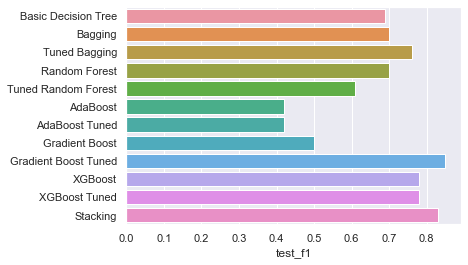

In [72]:
sns.barplot(x=model_scores.test_f1, y=model_scores.index, orient="h");

As the stats above exhibit, the Tuned Gradient Boost model was by far the most performant with my focus on F1 (although it scored highest or second highest of all models on all metrics). Stacking did really well, too, but it incorporated the Tuned Gradient Boost within it.

The model that overfits the worst was Basic Decision Tree, as expected.

The AdaBoost models are interesting because they don't seem to overfit any if at all, but they also aren't very performant for the relevant metric.

MonthlyIncome, Age, DurationOfPitch, and Passport were the most influential features in the best model.

# Actionable Insights and Recommendations

We should use the Tuned Gradient Boost model to assess the likelihood of future customers buying our various products to target marketing efforts and eliminate the "overmarketing" that prompted this analysis to begin with. Corporate spending will be better targeted, and will make the company more cost-effective.

Whereas previous marketing efforts were done in a non-data-driven manner most likely via sales team business intuition, now we have a model that can predict customer outcomes with a high degree of confidence given their data.

The company will now be able to target those customers that it already successfully targeted in addition to targeting customers that it didn't target in the past but would have purchased a product.

The ultimate goal is to determine who should be marketed for a new product that is based on a healthy lifestyle, but there is no empirical data regarding customers with healthy lifestyles, specifically, so I would work with Subject Matter Experts in marketing to identify data points that we do have that would logically flow with a healthy lifestyle customer.

For example, perhaps customers with a desire to focus on their health have a certain income, tend to be single, and live in a certain type of city. That's where marketing expertise would come in handy.

Another option would be to do a screening test via survey perhaps to try and find the features most correlated to healthy lifestyle as well.